# Unsupervised Learning

Looks for previously undetected patterns in a data set with no pre-existing labels with a minimum of human supervision. Also known as *self-organization* allows for modeling of probability densities of inputs.

Given, $N$ training examples
$\{x_1,\dots,x_N\} = \bf{X}$

Often use:
* **Dimensionality reduction** (of the input feature vectors)
* **Clustering** (to find clusters of similar samples)

A central theme of unsupervised learning is the field of density of estimation in statistics, it intends to infer a prior probability distribution for $\bf{X}$, i.e. $p_X(x)$

# Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).

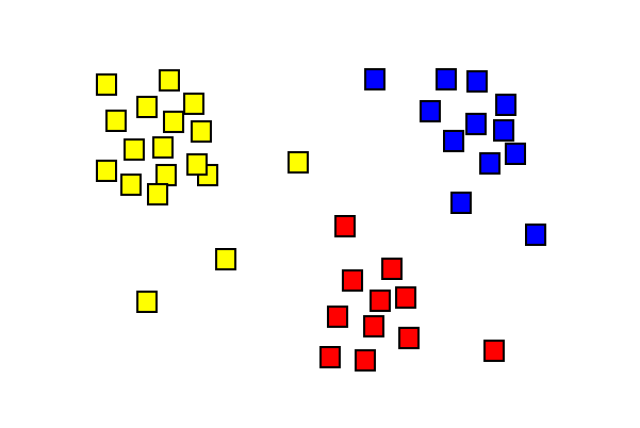

Cluster analysis itself is not one specific algorithm, but the general task to be solved. It can be achieved by various algorithms that differ significantly in their understanding of what constitutes a cluster and how to efficiently find them. Popular notions of clusters include groups with small distances between cluster members, dense areas of the data space, intervals or particular statistical distributions.

Module of `sklearn.cluster`. Each clustering algorithm class comes with SciKit-Learns `fit` and `predict` methods.

The notion of what forms a *cluster* varies, hence there are different algorithms of the form:
* **Centroid models** - `KMeans` represents each cluster by a single mean vector.
* **Connectivity models** - Hierarchical clustering `AgglomerativeClustering` builds models based on distance connectivity, `Birch`, `Affinity propagation` based on the concept of *message passing* between data points.
* **Distribution models** - Clusters are modeled using statstical distributions, such as `Gaussian mixtures`
* **Density models** - `DBSCAN`, `OPTICS`, `MeanShift` defines clusters as connected dense regions in the data space

## K-means


The `KMeans` algorithm clusters data by
trying to separate samples in n groups of equal variance, minimizing a
criterion known as the *inertia* or within-cluster sum-of-squares (see
below). This algorithm requires the number of clusters to be specified.
It scales well to large number of samples and has been used across a
large range of application areas in many different fields.

The k-means algorithm divides a set of $N$ samples $X$ into $K$ disjoint
clusters $C$, each described by the mean $\mu_j$ of the samples in the
cluster. The means are commonly called the cluster \"centroids\"; note
that they are not, in general, points from $X$, although they live in
the same space.

The K-means algorithm aims to choose centroids that minimise the
**inertia**, or **within-cluster sum-of-squares criterion**:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

Inertia can be recognized as a measure of how internally coherent
clusters are. It suffers from various drawbacks:

-   Inertia makes the assumption that clusters are convex and isotropic,
    which is not always the case. It responds poorly to elongated
    clusters, or manifolds with irregular shapes.
-   Inertia is not a normalized metric: we just know that lower values
    are better and zero is optimal. But in very high-dimensional spaces,
    Euclidean distances tend to become inflated (this is an instance of
    the so-called \"curse of dimensionality\"). Running a dimensionality
    reduction algorithm such as `PCA`
    prior to k-means clustering can alleviate this problem and speed up
    the computations.

K-means is often referred to as Lloyd\'s algorithm. In basic terms, the
algorithm has three steps. The first step chooses the initial centroids,
with the most basic method being to choose $k$ samples from the dataset
$X$. After initialization, K-means consists of looping between the two
other steps. The first step assigns each sample to its nearest centroid.
The second step creates new centroids by taking the mean value of all of
the samples assigned to each previous centroid. The difference between
the old and the new centroids are computed and the algorithm repeats
these last two steps until this value is less than a threshold. In other
words, it repeats until the centroids do not move significantly. In this implementation it
stops when centroids move less than the tolerance.

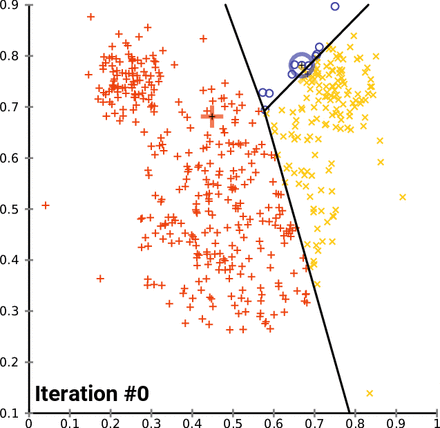

K-means is equivalent to the expectation-maximization algorithm with a
small, all-equal, diagonal covariance matrix.

Given enough time, K-means will always converge, however this may be to
a local minimum. This is highly dependent on the initialization of the
centroids. As a result, the computation is often done several times,
with different initializations of the centroids. One method to help
address this issue is the k-means++ initialization scheme, which has
been implemented in scikit-learn (use the `init='k-means++'` parameter).
This initializes the centroids to be (generally) distant from each
other, leading to provably better results than random initialization, as
shown in the reference.

The algorithm supports sample weights, which can be given by a parameter
`sample_weight`. This allows to assign more weight to some samples when
computing cluster centers and values of inertia. For example, assigning
a weight of 2 to a sample is equivalent to adding a duplicate of that
sample to the dataset $X$.



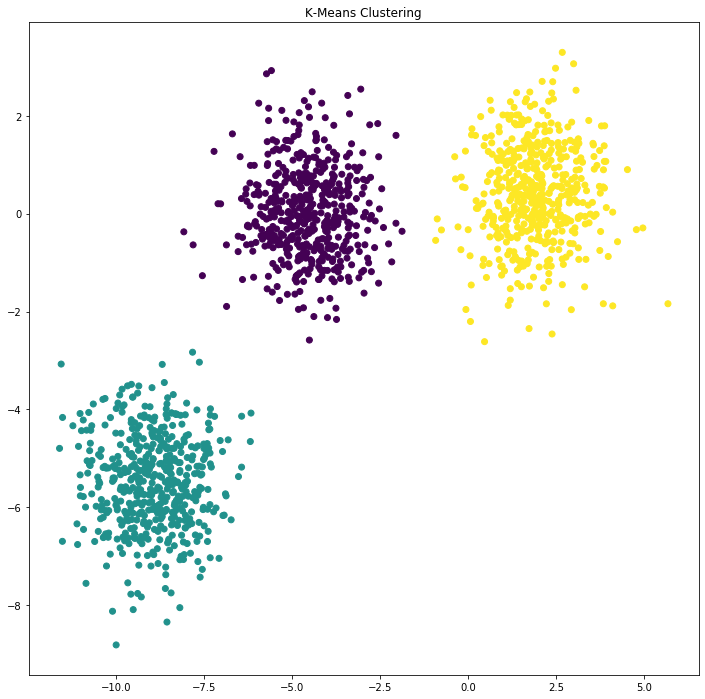

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("K-Means Clustering")

plt.show()

# Mini Batch K-Means

The `MiniBatchKMeans` is a variant of
the `KMeans` algorithm which uses
mini-batches to reduce the computation time, while still attempting to
optimise the same objective function. Mini-batches are subsets of the
input data, randomly sampled in each training iteration. These
mini-batches drastically reduce the amount of computation required to
converge to a local solution. In contrast to other algorithms that
reduce the convergence time of k-means, mini-batch k-means produces
results that are generally only slightly worse than the standard
algorithm.

The algorithm iterates between two major steps, similar to vanilla
k-means. In the first step, $b$ samples are drawn randomly from the
dataset, to form a mini-batch. These are then assigned to the nearest
centroid. In the second step, the centroids are updated. In contrast to
k-means, this is done on a per-sample basis. For each sample in the
mini-batch, the assigned centroid is updated by taking the streaming
average of the sample and all previous samples assigned to that
centroid. This has the effect of decreasing the rate of change for a
centroid over time. These steps are performed until convergence or a
predetermined number of iterations is reached.

`MiniBatchKMeans` converges faster than
`KMeans`, but the quality of the results
is reduced. In practice this difference in quality can be quite small,
as shown in the example and cited reference.

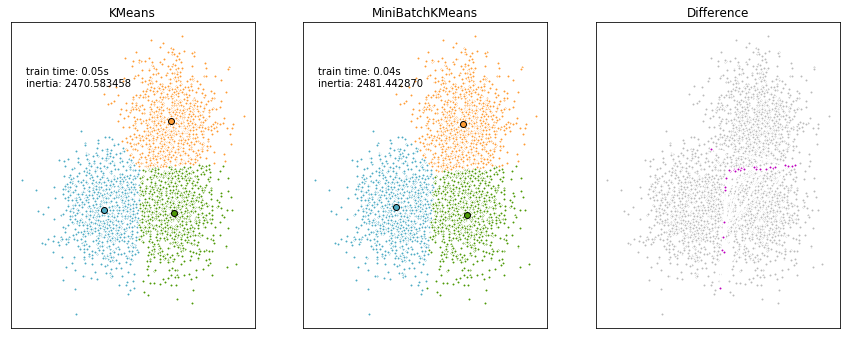

In [6]:
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

# Affinity Propagation

`AffinityPropagation` creates clusters
by sending messages between pairs of samples until convergence. A
dataset is then described using a small number of exemplars, which are
identified as those most representative of other samples. The messages
sent between pairs represent the suitability for one sample to be the
exemplar of the other, which is updated in response to the values from
other pairs. This updating happens iteratively until convergence, at
which point the final exemplars are chosen, and hence the final
clustering is given.


Estimated number of clusters: 3
Homogeneity: 0.872
Completeness: 0.872
V-measure: 0.872
Adjusted Rand Index: 0.912
Adjusted Mutual Information: 0.871
Silhouette Coefficient: 0.753


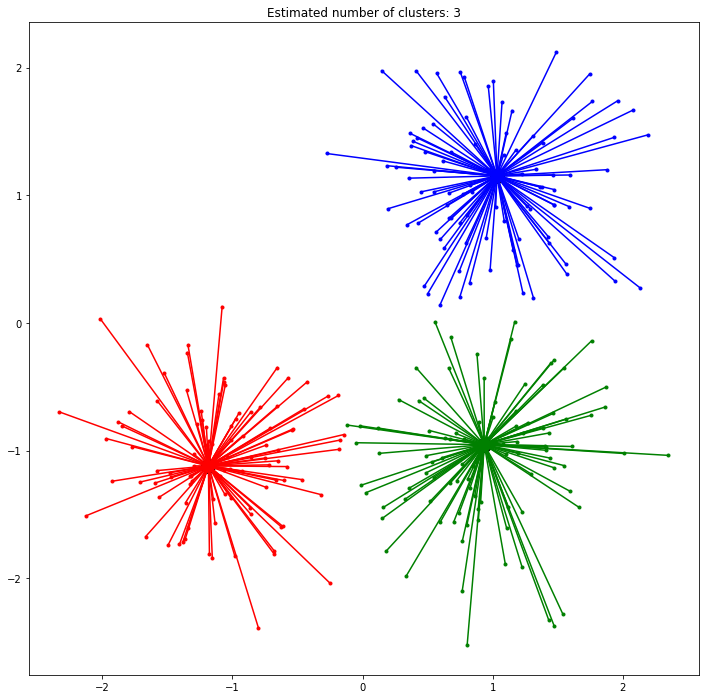

In [8]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
                            random_state=0)

# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1, figsize=(12,12))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


Affinity Propagation can be interesting as it chooses the number of
clusters based on the data provided. For this purpose, the two important
parameters are the *preference*, which controls how many exemplars are
used, and the *damping factor* which damps the responsibility and
availability messages to avoid numerical oscillations when updating
these messages.

The main drawback of Affinity Propagation is its complexity. The
algorithm has a time complexity of the order $O(N^2 T)$, where $N$ is
the number of samples and $T$ is the number of iterations until
convergence. Further, the memory complexity is of the order $O(N^2)$ if
a dense similarity matrix is used, but reducible if a sparse similarity
matrix is used. This makes Affinity Propagation most appropriate for
small to medium sized datasets.

**Algorithm description:** The messages sent between points belong to
one of two categories. The first is the responsibility $r(i, k)$, which
is the accumulated evidence that sample $k$ should be the exemplar for
sample $i$. The second is the availability $a(i, k)$ which is the
accumulated evidence that sample $i$ should choose sample $k$ to be its
exemplar, and considers the values for all other samples that $k$ should
be an exemplar. In this way, exemplars are chosen by samples if they are
(1) similar enough to many samples and (2) chosen by many samples to be
representative of themselves.

More formally, the responsibility of a sample $k$ to be the exemplar of
sample $i$ is given by:

$$r(i, k) \leftarrow s(i, k) - max [ a(i, k') + s(i, k') \forall k' \neq k ]$$

Where $s(i, k)$ is the similarity between samples $i$ and $k$. The
availability of sample $k$ to be the exemplar of sample $i$ is given by:

$$a(i, k) \leftarrow min [0, r(k, k) + \sum_{i'~s.t.~i' \notin \{i, k\}}{r(i', k)}]$$

To begin with, all values for $r$ and $a$ are set to zero, and the
calculation of each iterates until convergence. As discussed above, in
order to avoid numerical oscillations when updating the messages, the
damping factor $\lambda$ is introduced to iteration process:

$$r_{t+1}(i, k) = \lambda\cdot r_{t}(i, k) + (1-\lambda)\cdot r_{t+1}(i, k)$$

$$a_{t+1}(i, k) = \lambda\cdot a_{t}(i, k) + (1-\lambda)\cdot a_{t+1}(i, k)$$

where $t$ indicates the iteration times.

# Mean Shift

`MeanShift` clustering aims to discover
*blobs* in a smooth density of samples. It is a centroid based
algorithm, which works by updating candidates for centroids to be the
mean of the points within a given region. These candidates are then
filtered in a post-processing stage to eliminate near-duplicates to form
the final set of centroids.

Given a candidate centroid $x_i$ for iteration $t$, the candidate is
updated according to the following equation:

$$x_i^{t+1} = m(x_i^t)$$

Where $N(x_i)$ is the neighborhood of samples within a given distance
around $x_i$ and $m$ is the *mean shift* vector that is computed for
each centroid that points towards a region of the maximum increase in
the density of points. This is computed using the following equation,
effectively updating a centroid to be the mean of the samples within its
neighborhood:

$$m(x_i) = \frac{\sum_{x_j \in N(x_i)}K(x_j - x_i)x_j}{\sum_{x_j \in N(x_i)}K(x_j - x_i)}$$

The algorithm automatically sets the number of clusters, instead of
relying on a parameter `bandwidth`, which dictates the size of the
region to search through. This parameter can be set manually, but can be
estimated using the provided `estimate_bandwidth` function, which is
called if the bandwidth is not set.

The algorithm is not highly scalable, as it requires multiple nearest
neighbor searches during the execution of the algorithm. The algorithm
is guaranteed to converge, however the algorithm will stop iterating
when the change in centroids is small.

Labelling a new sample is performed by finding the nearest centroid for
a given sample.

number of estimated clusters : 3


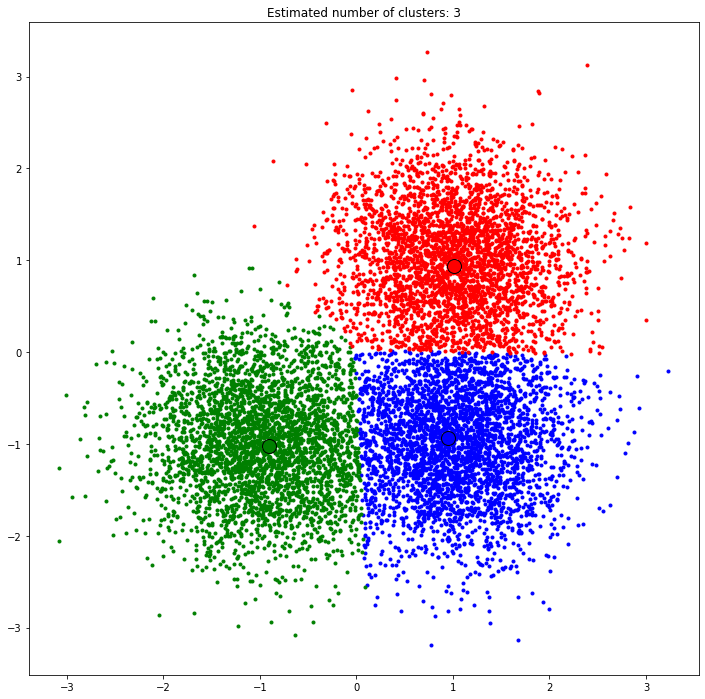

In [12]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, _ = make_blobs(n_samples=10000, centers=centers, cluster_std=0.6)

# #############################################################################
# Compute clustering with MeanShift

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1 ,figsize=(12,12))
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Spectral Clustering

`SpectralClustering` performs a
low-dimension embedding of the affinity matrix between samples, followed
by clustering, e.g., by KMeans, of the components of the eigenvectors in
the low dimensional space. It is especially computationally efficient if
the affinity matrix is sparse and the [amg]{.title-ref} solver is used
for the eigenvalue problem (Note, the [amg]{.title-ref} solver requires
that the [pyamg](https://github.com/pyamg/pyamg) module is installed.)

The present version of SpectralClustering requires the number of
clusters to be specified in advance. It works well for a small number of
clusters, but is not advised for many clusters.

For two clusters, SpectralClustering solves a convex relaxation of the
[normalised
cuts](https://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf)
problem on the similarity graph: cutting the graph in two so that the
weight of the edges cut is small compared to the weights of the edges
inside each cluster. This criteria is especially interesting when
working on images, where graph vertices are pixels, and weights of the
edges of the similarity graph are computed using a function of a
gradient of the image.

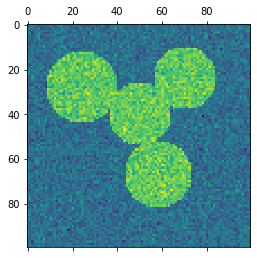

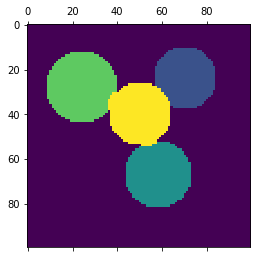

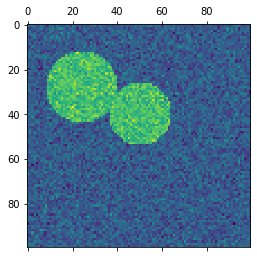

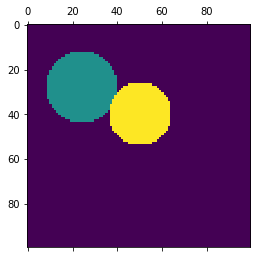

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

# #############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(img, mask=mask)

# Take a decreasing function of the gradient: we take it weakly
# dependent from the gradient the segmentation is close to a voronoi
graph.data = np.exp(-graph.data / graph.data.std())

# Force the solver to be arpack, since amg is numerically
# unstable on this example
labels = spectral_clustering(graph, n_clusters=4, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

# #############################################################################
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver='arpack')
label_im = np.full(mask.shape, -1.)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

# Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms
that build nested clusters by merging or splitting them successively.
This hierarchy of clusters is represented as a tree (or dendrogram). The
root of the tree is the unique cluster that gathers all the samples, the
leaves being the clusters with only one sample. See the [Wikipedia page
\<https://en.wikipedia.org/wiki/Hierarchical\_clustering\>]() for more
details.

The `AgglomerativeClustering` object
performs a hierarchical clustering using a bottom up approach: each
observation starts in its own cluster, and clusters are successively
merged together. The linkage criteria determines the metric used for the
merge strategy:

-   **Ward** minimizes the sum of squared differences within all
    clusters. It is a variance-minimizing approach and in this sense is
    similar to the k-means objective function but tackled with an
    agglomerative hierarchical approach.
-   **Maximum** or **complete linkage** minimizes the maximum distance
    between observations of pairs of clusters.
-   **Average linkage** minimizes the average of the distances between
    all observations of pairs of clusters.
-   **Single linkage** minimizes the distance between the closest
    observations of pairs of clusters.

`AgglomerativeClustering` can also scale
to large number of samples when it is used jointly with a connectivity
matrix, but is computationally expensive when no connectivity
constraints are added between samples: it considers at each step all the
possible merges.

`AgglomerativeClustering` supports Ward, single, average, and complete linkage strategies.

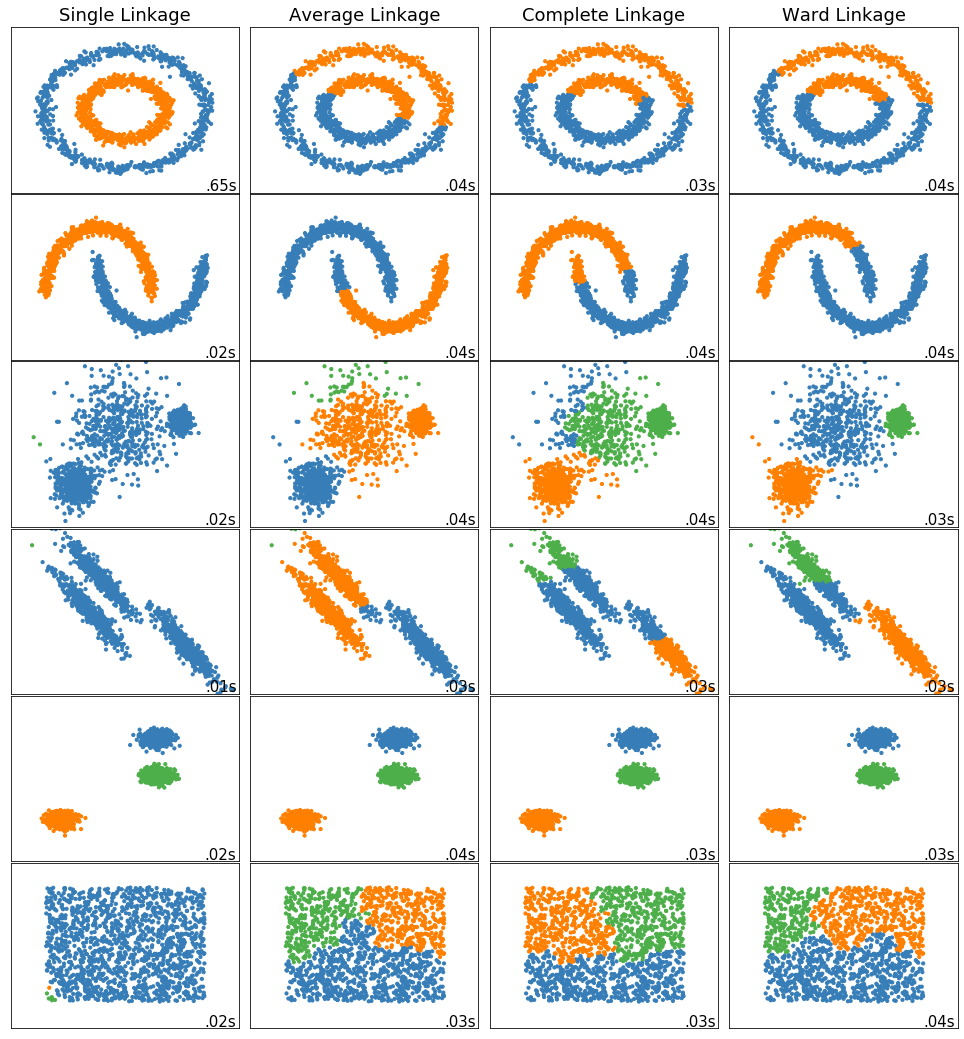

In [14]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

### Generate datasets
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)


# Set up cluster parameters
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward')
    complete = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='complete')
    average = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='average')
    single = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='single')

    clustering_algorithms = (
        ('Single Linkage', single),
        ('Average Linkage', average),
        ('Complete Linkage', complete),
        ('Ward Linkage', ward),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()


Agglomerative cluster has a “rich get richer” behavior that leads to uneven cluster sizes. In this regard, single linkage is the worst strategy, and Ward gives the most regular sizes. However, the affinity (or distance used in clustering) cannot be varied with Ward, thus for non Euclidean metrics, average linkage is a good alternative. Single linkage, while not robust to noisy data, can be computed very efficiently and can therefore be useful to provide hierarchical clustering of larger datasets. Single linkage can also perform well on non-globular data.

## Visualization of cluster hierarchy

It’s possible to visualize the tree representing the hierarchical merging of clusters as a dendrogram. Visual inspection can often be useful for understanding the structure of the data, though more so in the case of small sample sizes.



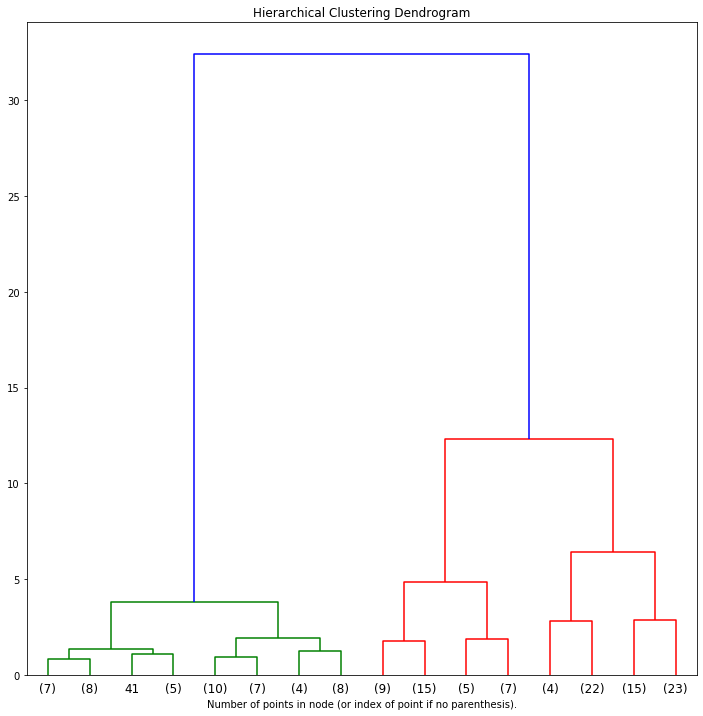

In [18]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


iris = load_iris()
X = iris.data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.figure(1 ,figsize=(12,12))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Adding connectivity contraints

An interesting aspect of AgglomerativeClustering is that connectivity constraints can be added to this algorithm (only adjacent clusters can be merged together), through a connectivity matrix that defines for each sample the neighboring samples following a given structure of the data. For instance, in the swiss-roll example below, the connectivity constraints forbid the merging of points that are not adjacent on the swiss roll, and thus avoid forming clusters that extend across overlapping folds of the roll.

Compute unstructured hierarchical clustering...
Elapsed time: 0.04s
Number of points: 1500
Compute structured hierarchical clustering...
Elapsed time: 0.08s
Number of points: 1500


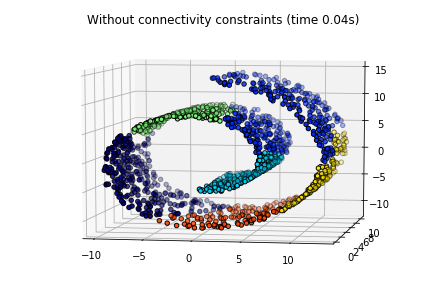

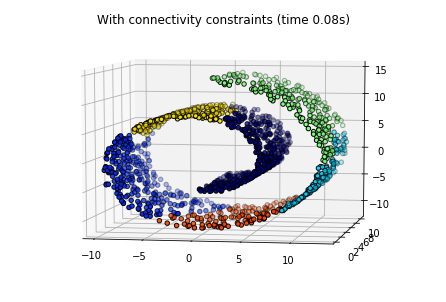

In [19]:
import time as time
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll

# #############################################################################
# Generate data (swiss roll dataset)
n_samples = 1500
noise = 0.05
X, _ = make_swiss_roll(n_samples, noise)
# Make it thinner
X[:, 1] *= .5

# #############################################################################
# Compute clustering
print("Compute unstructured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)


# #############################################################################
# Define the structure A of the data. Here a 10 nearest neighbors
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

# #############################################################################
# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
ward = AgglomerativeClustering(n_clusters=6, connectivity=connectivity,
                               linkage='ward').fit(X)
elapsed_time = time.time() - st
label = ward.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

# #############################################################################
# Plot result
fig = plt.figure()
ax = p3.Axes3D(fig)
ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X[label == l, 0], X[label == l, 1], X[label == l, 2],
               color=plt.cm.jet(float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('With connectivity constraints (time %.2fs)' % elapsed_time)

plt.show()

These constraint are useful to impose a certain local structure, but
they also make the algorithm faster, especially when the number of the
samples is high.

The connectivity constraints are imposed via an connectivity matrix: a
scipy sparse matrix that has elements only at the intersection of a row
and a column with indices of the dataset that should be connected. This
matrix can be constructed from a-priori information: for instance, you
may wish to cluster web pages by only merging pages with a link pointing
from one to another.

# DBSCAN

